In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

# seed
torch.manual_seed(113)
torch.cuda.manual_seed(113)
np.random.seed(113)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset

In [2]:
train_dir = "train/"
test_dir = "test/"

In [16]:
train_transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.RandomRotation(5), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


test_transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_img = datasets.ImageFolder(train_dir, transform=train_transform)
test_img = datasets.ImageFolder(test_dir, transform=test_transform)

# Explore the Data

In [17]:
print("train_img type   :",type(train_img))
print("train_img length :",len(train_img))
print("test_img length :",len(test_img))
print("train_img classes:",train_img.classes)
print("train_img[0] type:",type(train_img[0]))
print("train_img[0][0] t:",type(train_img[0][0]))
print("train_img[0][1] t:",type(train_img[0][1]))
print("train_img[0][0] s:",train_img[0][0].size())
print("train_img[0][1]  :",train_img[0][1])

train_img type   : <class 'torchvision.datasets.folder.ImageFolder'>
train_img length : 940
test_img length : 120
train_img classes: ['JUICE', 'MILK', 'SODA', 'VINEGAR', 'WATER']
train_img[0] type: <class 'tuple'>
train_img[0][0] t: <class 'torch.Tensor'>
train_img[0][1] t: <class 'int'>
train_img[0][0] s: torch.Size([3, 150, 150])
train_img[0][1]  : 0


In [18]:
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5],)
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

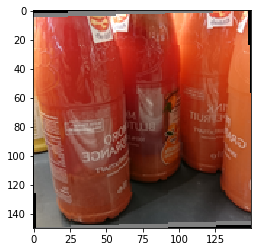

JUICE


In [19]:
imshow(train_img[0])

# Create the Loader

In [20]:
trainloaders = torch.utils.data.DataLoader(train_img, batch_size=64, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=32, shuffle=True)

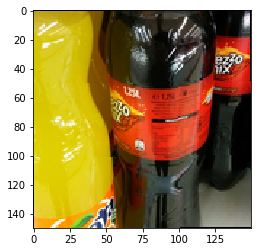

SODA


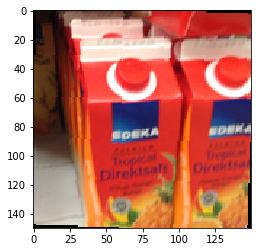

JUICE


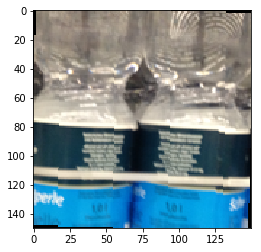

WATER


In [21]:
for image, label in trainloaders:
    for i in range(3):
        imshow((image[i], label[i]))
    break

# Create the Architecture

In [33]:
class Net(nn.Module):
    
    #  Convolution size formula (W-K+2P)/S+1
    #  Pooling size formula
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(39200, 512)
        self.fc2 = nn.Linear(512, 5)
        self.do = nn.Dropout()
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.do(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [34]:
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 20

In [35]:
model.train()

for i in range(epoch):
    total_loss = 0
    total_sample = 0    
    total_correct = 0
    
    for image, label in trainloaders:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        
        loss = criterion(out, label)
        total_loss += loss.item()
        total_sample += len(label)
        total_correct += torch.sum(torch.max(out,1)[1]==label).item()*1.0
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", i, total_loss/total_sample, total_correct/total_sample)

epoch 0 0.03158918555746687 0.30638297872340425
epoch 1 0.021654276264474748 0.39787234042553193
epoch 2 0.01974692699757028 0.46702127659574466
epoch 3 0.016911600435033758 0.573404255319149
epoch 4 0.01565206139645678 0.6127659574468085
epoch 5 0.014037869712139698 0.6574468085106383
epoch 6 0.012708531859073233 0.7117021276595744
epoch 7 0.01176068681351682 0.7202127659574468
epoch 8 0.011041647449452826 0.7425531914893617
epoch 9 0.010299336720020213 0.7574468085106383
epoch 10 0.010010424922121333 0.7446808510638298
epoch 11 0.00836389809846878 0.7968085106382978
epoch 12 0.007583685124174078 0.8297872340425532
epoch 13 0.006645223213003037 0.8361702127659575
epoch 14 0.006223527770093147 0.8563829787234043
epoch 15 0.005572409499832925 0.8787234042553191
epoch 16 0.005180954552711324 0.8978723404255319
epoch 17 0.004727678317972954 0.9063829787234042
epoch 18 0.004239923189929191 0.8978723404255319
epoch 19 0.0036402822967539442 0.9287234042553192


In [36]:
model.eval()
total_loss = 0
total_sample = 0    
total_correct = 0

for image, label in testloaders:
    image = image.to(device)
    label = label.to(device)
    
    out = model(image)

    loss = criterion(out, label)
    total_loss += loss.item()
    total_sample += len(label)
    total_correct += torch.sum(torch.max(out, 1)[1] == label).item()*1.0


print("test loss", total_loss/total_sample)
print("test accuracy", total_correct/total_sample)

test loss 0.034037228922049204
test accuracy 0.7083333333333334


# Sanity Check

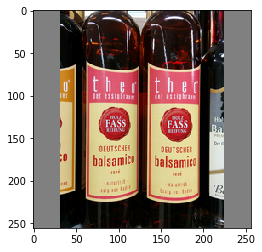

In [37]:
imagepath = "VINEGAR0139.png"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [38]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[-0.4855, -9.1041, -0.5697, 11.0146, -7.4217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
PREDICTION: VINEGAR
